# Notebook
$\newcommand{\arcsec}{"}$
$\newcommand{\AA}{Å}$

C. J. Díaz Baso$^{1,2}$ and A. Asensio Ramos$^{1,2}$

1 Instituto de Astrofísica de Canarias, Calle Vía Láctea, 38205 La Laguna, Tenerife, Spain  
2 Departamento de Astrofísica, Universidad de La Laguna, 38206 La Laguna, Tenerife, Spain

---

In this chapter we will learn how to use and apply deep learning tecniques to improve the resolution of our images in a fast and robust way. We have developed a deep fully convolutional neural network which deconvolves and super-resolves continuum images and magnetograms observed with the Helioseismic and Magnetic Imager (HMI) satellite. This improvement allow us to analyze the smallest-scale events in the solar atmosphere.

We want to note that although almost all the examples/images are written in python, we have omitted some materials in their original format (usually large FITS files) to avoid increasing the size of this notebook.

The software resulted from this project is hosted in the repository https://github.com/cdiazbas/enhance, which was published in [arxiv](https://arxiv.org/pdf/1706.02933.pdf) and [A&A](https://www.aanda.org/articles/aa/pdf/2018/06/aa31344-17.pdf) with a similar explanation. This software was developed with the python library [keras](https://keras.io/). We recommend visiting the `keras` documentation for anything related to how it works.

![example](docs/imagen.gif)
**Figure 1** — Example of the software `Enhance` applied to real solar images.

In [1]:
# Before starting we have to load some modules
# which will allow us the calculations

# Libraries:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from congrid import resample
import radialProfile 
from hmiutils import *
from astropy.convolution import convolve_fft
import astropy.io.fits as fits
import scipy.special as sp

---

## Introduction
Astronomical observations from Earth are always limited by the presence of the atmosphere, which strongly disturbs
the images. An obvious (but expensive) solution to this problem is to place the telescopes in space, which produces observations without any (or limited) atmospheric aberrations. Although the observations obtained from space are not affected by atmospheric seeing, the optical properties of the instrument still limits the observations.

In the case of near-diffraction limited observations, the point spread function (PSF) establishes the maximum allowed
spatial resolution. The PSF typically contains two different contributions. The central core is usually dominated by the Airy diffraction pattern, a consequence of the finite and circular aperture of the telescope (plus other perturbations
on the pupil of the telescope like the spiders used to keep the secondary mirror in place). The tails of the PSF are
usually dominated by uncontrolled sources of dispersed light inside the instrument, the so-called stray light. It is known that the central core limits the spatial resolution of the observations (the smallest feature that one can see in the image), while the tails reduce the contrast of the image [(Danilovic et al. 2010)](#references). Moreover, it is important to note that knowing the PSF of any instrument is a very complicated task [(Yeo et al. 2014; Couvidat et al. 2016)](#references).

If the PSF is known with some precision, it is possible to apply deconvolution techniques to partially remove the perturbing effect of the telescope. The deconvolution is usually carried out with the Richardson-Lucy algorithm (RL; [Richardson 1972](#references)), an iterative procedure that returns a maximum-likelihood solution to the problem.
Single-image deconvolution is usually a very ill-defined problem, in which a potentially infinite number of solutions can be compatible with the observations. Consequently, some kind of regularization has to be imposed. Typically, an early-stopping strategy in the iterative process of the RL algorithm leads to a decent output, damping the high spatial frequencies that appear in any deconvolution process. However, a maximum a-posteriori approach in which
some prior information about the image is introduced often gives much better results.


<img align="right" src="https://img.purch.com/h/1400/aHR0cDovL3d3dy5zcGFjZS5jb20vaW1hZ2VzL2kvMDAwLzAzMS8wOTgvb3JpZ2luYWwvc2RvLWRldGFpbGVkLmpwZw==" width="40%"/>


Fortunately, spectroscopic and spectropolarimetric observations provide multi-image observations of a field-of-view (FOV) and the deconvolution process is much better defined. This deconvolution process has been tried recently with
great success by [van Noort (2012)](#references), who also introduced a strong regularization by assuming that the Stokes profiles in every pixel have to be explained with the emerging Stokes profiles from a relatively simple model atmosphere assuming local thermodynamical equilibrium. Another solution was provided by [Ruiz Cobo & Asensio Ramos (2013)](#references), who assumed that the matrix built with the Stokes profiles for all observed pixels has very low rank. In other words, it means that the Stokes profiles on the FOV can be linearly expanded with a reduced set of vectors. This method was later exploited by [Quintero Noda et al. (2015)](#references) with good results. Another different approach was developed by [Asensio Ramos & de la Cruz Rodríguez (2015)](#references) where they used the concept of sparsity (or compressibility), which means that one can linearly expand the unknown quantities in a basis set with only a few of the elements of the basis set being active. Under the assumption of sparsity, they exploited the presence of spatial correlation on the maps of physical parameters, carrying out successful inversions and deconvolution simultaneously.




A great science case for the application of deconvolution and super-resolution techniques is the Helioseismic and Magnetic Imager [(HMI; Scherrer et al. 2012)](#references) onboard the Solar Dynamics Observatory (SDO; [Pesnell et al. 2012](#references)). HMI is a space-borne observatory that deploys full-disk images (plus a magnetogram and Dopplergram) of the Sun every 45 s (or every 720 s for a better signal-to-noise ratio). The spatial resolution of these images is  $\sim 1.1''$, with a sampling of $\sim 0.5''$/pix. In spite of the enormous advantage of having such a synoptic spatial telescope without the problematic Earth's atmosphere, the spatial resolution is not enough to track many of the small-scale solar structures of interest. The main reason for that is the sacrifice that HMI makes to cover the full disk of the Sun in the FOV on a single sensor. We think that, in the process of pushing for the advancement of science, 
it is preferable to have images with a better spatial resolution and which are already compensated for the telescope PSF. 

Under the assumption of the linear theory of image formation, and writing images in lexicographic order (so that they are assumed to be sampled at a given resolution), the observed image can be written as:

\begin{equation}
\mathbf{I} = \mathbf{D} [\mathbf{P} * \mathbf{O}] + \mathbf{N},                             \tag{1}
\end{equation}



where $\mathbf{O}$ is the solar image at the entrance of the telescope, $\mathbf{P}$ is a convolution matrix that simulates the effect of the PSF on the image, $\mathbf{D}$ is a sub-sampling (non-square) matrix that reduces the
resolution of the input image to the desired output spatial resolution and $\mathbf{N}$ represents noise (usually with Gaussian or Poisson statistics). The solution to the single-image deconvolution+super-resolution problem (SR; [Borman & Stevenson 1998](#references)) requires the recovery of $\mathbf{O}$ (a high-resolution image of $2N \times 2N$ pixels) from a single measurement $\mathbf{I}$ (a low-resolution image of $N \times N$ pixels). This problem is extremely ill-posed, even worse than the usual deconvolution to correct from the effect of the PSF. A multiplicity (potentially an infinite number) of solutions exists. This problem is then typically solved by imposing strong priors on the image (e.g., [Tipping & Bishop 2003](#references)).

Despite the difficulty of the problem, we think there is great interest in enhancing the HMI images using post-facto
techniques. A super-resolved image could help detect or characterize small features in the surface of the Sun, or improve
the estimation of the total magnetic flux limited by the resolution in the case of magnetograms. This motivated us to develop an end-to-end fast method based on a deep, fully convolutional neural network that simultaneously deconvolves and super-resolves the HMI continuum images and magnetograms by a factor of two. We prefer to be conservative and only do super-resolution by a factor two because our tests with a larger factor did not produce satisfactory results.
Deep learning, single-image deconvolution and super-resolution has recently been applied with great success to natural images [(Xu et al. 2014; Dong et al. 2015, 2016; Shi et al. 2016; Ledig et al. 2016; Hayat 2017)](#references). Given the variability of all possible natural images, a training-based approach should give much better results in our case than in the case of natural images. In the following, we give details about the architecture and training of the neural network and provide examples of applications to HMI data.

<a id="fig:networks"></a>
<img align="left" src="docs/fullc.png" width="40%"/> <img align="center" src="docs/ConvLayer.png" width="50%"/>

**Figure 2** — Left panel: building block of a fully-connected neural network. Each input of the previous 
layer is connected to each neuron of the output. Each connection is represent by different 
lines where the width is associated to higher weights and the dashed lines to negative weights. 
Right panel: three-dimensional convolution carried out by a convolutional layer. The 3D-kernel traverses
the whole input, producing a single scalar at each position. At the end, a 2D feature map will be 
created for each 3D kernel. When all feature maps are stacked, a feature map tensor will be created.

---

## Deep convolutional neural networks


### Deep neural networks

Artificial neural networks (ANN) are well-known computing systems based on connectionism that can be considered to be very powerful approximators to arbitrary functions [(Bishop 1996)](#references). They are constructed by putting together many basic fundamental structures (called neurons) and connecting them massively. Each neuron $i$ is only able to carry out a very basic operation on the input vector: it multiplies all the input values $x_j$ by some weights $w_j$, adds some bias $b_i$ and finally returns the value of a certain user-defined nonlinear activation function $f(x)$. In mathematical notation, a neuron computes:

\begin{equation}
o_i = f(\Sigma_j\,x_j\cdot w_j + b_i).              \tag{2}
\end{equation}


The output $o_i$ is then input in another neuron that carries out a similar task. An ANN can be understood as a pipeline where the information goes from the input to the output, with each neuron making a transformation like the one described above (see left panel of Fig. [2](#fig:networks)). Given that neurons are usually grouped in layers, the term deep neural network comes from the large number of layers that are used to build the neural network. Some of the most successful and recent neural networks contain several million neurons organized in several tens or hundreds of layers [(Simonyan & Zisserman 2014)](#references). As a consequence, deep neural networks can be considered to be a very complex composition of very simple nonlinear functions, which provides the capacity to make very complex transformations.

The most used type of neural network from the 1980s to the 2000s is the fully connected network (FCN; see [Schmidhuber 2014](#references), for an overview), in which every input is connected to every neuron of the following layer. Likewise, the output transformation becomes the input of the following layer (see left panel of Fig. [2](#fig:networks)).
This kind of architecture succeeded in solving problems that were considered to be not easily solvable, such as the recognition of handwritten characters [(Bishop 1996)](#references). A selection of applications in solar physics include the inversion of Stokes profiles (e.g., [Socas-Navarro 2005; Carroll & Kopf 2008](#references)), the acceleration of the solution of chemical equilibrium [(Asensio Ramos & Socas-Navarro 2005)](#references), and the automatic classification of sunspot groups [(Colak & Qahwaji 2008)](#references).

Neural networks are optimized iteratively by updating the weights and biases so that 
a loss function that measures the ability of the network to predict the output from the input 
is minimized[$^{[1]}$](#footnote1). This optimization is widely known as 
the learning or training process. In this process a training dataset is required.

<a id="footnote1"></a>
> 1.- This is the case of supervised training. Unsupervised neural networks are also widespread but are of no concern in this study.

### Convolutional neural networks
In spite of the relative success of neural networks, their application to high-dimensional objects like images or videos turned out to be an obstacle. The fundamental reason was that the number of weights in a fully connected network increases extremely fast with the complexity of the network (number of neurons) and the computation quickly becomes unfeasible. As each neuron has to be connected with the whole input, if we add a new neuron we will add the size of the input in number of weights. Then, a larger number of neurons implies a huge number of connections. This constituted an apparently unsurmountable handicap that was only solved with the appearance of convolution neural networks (CNN
or ConvNets; [LeCun & Bengio 1998](#references)).

The most important ingredient in the CNN is the convolutional layer which is composed of several convolutional neurons. Each CNN neuron carries out the convolution of the input with a certain (typically small) kernel, providing as output what is known as a feature map. Similar to a FCN, the output of convolutional neurons is often passed through a nonlinear activation function. The fundamental advantage of CNNs is that the same weights are shared across the whole input, 
drastically reducing the number of unknowns. This also makes CNN shift invariant (features can be detected in an image irrespectively of where they are located). 

In mathematical notation, for a two-dimensional input $X$ of size $N \times N$ with $C$ channels[$^{[2]}$](#footnote2) 
(really a cube or tensor of size $N \times N \times C$), each output feature map $O_i$ (with size $N \times N \times 1$) of a convolutional layer is computed as:

\begin{equation}
O_i=K_i * X + b_i,               \tag{3}
\end{equation}

where $K_i$ is the $K \times K \times C$ kernel tensor associated with the output feature map $i$, $b_i$ is a bias value ($1 \times 1 \times 1$) and the convolution is displayed with the symbol $*$. Once the convolution with $M$ different kernels is carried out and stacked together, the output $O$ will have size $N \times N \times M$. All convolutions are here indeed intrinsically three dimensional, but one could see them as the total of $M \times C$ two-dimensional convolutions plus the bias (see right panel of Fig. [2](#fig:networks)).

<a id="footnote2"></a>
> 2.- The term "channels" is inherited from those of a color image (e.g., RGB channels). However, the term has a much more general scope and can be used for arbitrary quantities (see [Asensio Ramos et al. 2017](#references), an application).


CNNs are typically composed of several layers. This layered architecture exploits the property that many natural signals are generated by a hierarchical composition of patterns. For instance, faces are composed of eyes, while eyes contain a similar internal structure. This way, one can devise specific kernels that extract this information from the input. As an example, Fig. [3](#fig:featuremap) shows the effect of a vertical border detection kernel on a real solar image. The result at the right of the figure is the feature map. CNNs work on the idea that each convolution layer extracts information about certain patterns, which is done during the training by iteratively adapting the set of convolutional kernels to the specific features to locate. This obviously leads to a much more optimal solution as compared with hand-crafted kernels. Despite the exponentially smaller number of free parameters as compared with a fully connected ANN, CNNs produce much better results. It is interesting to note that, since a convolutional layer simply computes sums and multiplications of the inputs, a multi-layer FCN (also known as perceptron) is perfectly capable of reproducing it, but it would require more training time (and data) to learn to approximate that mode of operation 
[(Peyrard et al. 2015)](#references).

Although a convolutional layer significantly decreases the number of free parameters as compared with a fully connected layer, it introduces some hyperparameters (global characteristics of the network) to be set in advance: the number of kernels to be used (number of feature maps to extract from the input), size of each kernel with its corresponding padding (to deal with the borders of the image) and stride (step to be used during the convolution operation), and the number of convolutional layers and specific architecture to use in the network. As a general rule, the deeper the CNN, the better the result, at the expense of a more difficult and computationally intensive training. CNNs have recently been used in astrophysics for denoising images of galaxies [(Schawinski et al. 2017)](#references), for cosmic string detection in CMB temperature maps [(Ciuca et al. 2017)](#references), and for the estimation of horizontal velocities in the solar surface [(Asensio Ramos et al. 2017)](#references) .


<a id="fig:featuremap"></a>
<img src="docs/convolution2.png" width="90%"/>

**Figure 3** —  An example of a convolution with a filter. In this example, a vertical border-locating
kernel is convolved with the input image of the Sun. A resulting feature map of size
$(N-2)\times(N-2)$ is generated from the convolution.

### Activation layers

As stated above, the output of a convolutional layer is often passed through a nonlinear function  that is termed the activation function. Since the convolution operation is linear, this activation is the one that introduces the nonlinear character of the CNNs. Although hyperbolic tangent, $f(x)=\tanh(x)$, or sigmoidal, $f(x)=[1+\exp(-x)]^{-1}$, activation units were originally used in ANNs, nowadays a panoply of more convenient nonlinearities are used. The main problem 
with any sigmoid-type activation function is that its gradient vanishes for very large values, hindering the training of the network. Probably the most common activation function is the rectified linear unit (ReLU; [Nair & Hinton 2010](#references)) or slight variations of it. The ReLU replaces all negative values in the input by zero and leaves the rest untouched. This activation has the desirable property of producing nonvanishing gradients for positive arguments, which greatly accelerates the training.

> Note: there is a lot of other new activation functions which are less used but they have an excellent performance, like ELUs (https://arxiv.org/abs/1511.07289)

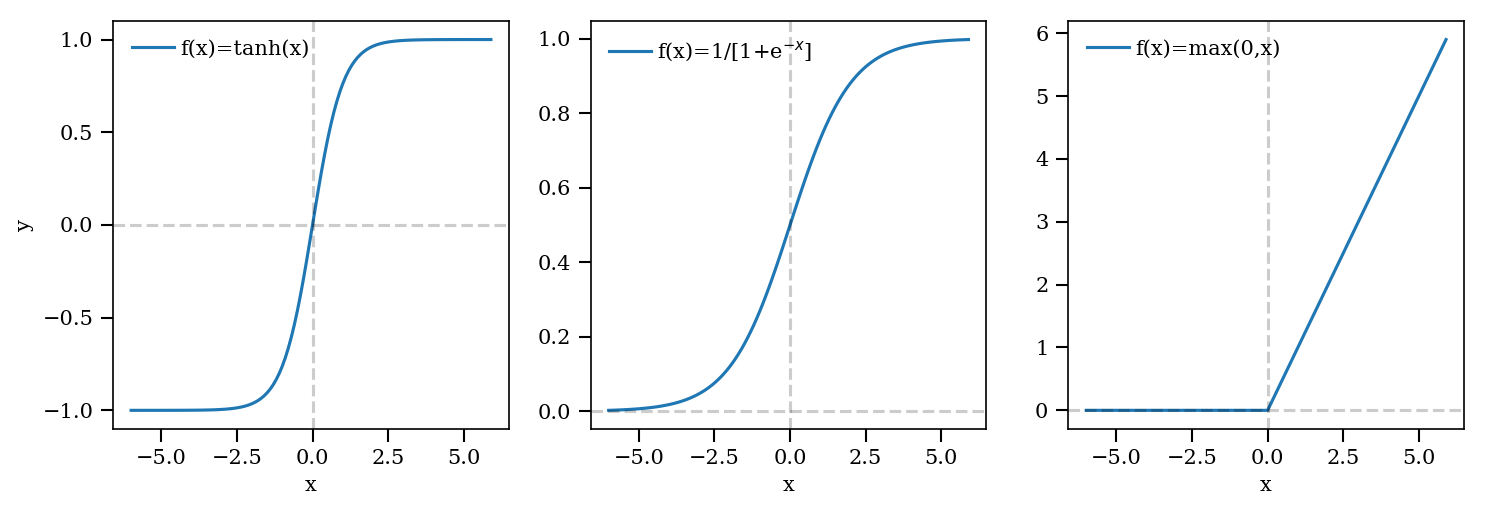

In [2]:
plt.rcParams['figure.dpi'] = 150
plt.figure(figsize=(10,3.5))
x = np.arange(-6,6,0.1)
plt.subplot(131)
plt.plot(x,np.tanh(x), label='f(x)=tanh(x)')
plt.yticks([+1,0.5,0,-0.5,-1])
plt.axvline(0., color='k',ls='dashed',alpha=0.2)
plt.axhline(0., color='k',ls='dashed',alpha=0.2)
plt.legend(loc='upper left'); plt.xlabel('x'); plt.ylabel('y')

plt.subplot(132)
plt.plot(x,1./(1+np.exp(-x)), label=r'f(x)=1/[1+e$^{-x}$]')
plt.axvline(0., color='k',ls='dashed',alpha=0.2)
plt.axhline(0., color='k',ls='dashed',alpha=0.2)
plt.legend(loc='upper left'); plt.xlabel('x')

plt.subplot(133)
plt.plot(x,[np.max([0,i]) for i in x], label='f(x)=max(0,x)')
plt.axvline(0., color='k',ls='dashed',alpha=0.2)
plt.axhline(0., color='k',ls='dashed',alpha=0.2)
plt.legend(loc='upper left'); plt.xlabel('x')
plt.tight_layout()

### General training process

CNNs are trained by iteratively modifying the weights and biases of the convolutional layers (and any other possibly learnable parameter in the activation layer). The aim is to optimize a user-defined loss function from the output
of the network and the desired output of the training data. The optimization is routinely solved using simple first-order gradient-descent algorithms (GD; see [Rumelhart et al. 1988](#references)), which modifies the weights along
the negative gradient of the loss function with respect to the model parameters to carry out the update. The gradient of the loss function with respect to the free parameters of the neural network is obtained through the backpropagation algorithm [(LeCun et al. 1998)](#references). Given that neural networks are defined as a stack of modules (or layers), the gradient of the loss function can be calculated using the chain rule as the product of the gradient of each module and, ultimately, of the last layer and the specific loss function.

In practice, procedures based on the so-called stochastic gradient descent (SGD) are used, in which only a few examples (termed batch) from the training set are used during each iteration to compute a noisy estimation of the gradient and adjust the weights accordingly. Although the calculated gradient is a noisy estimation of the one calculated with the whole training set, the training is faster, as we have less to compute, and is more reliable. If the general loss function $Q$ is the average of each loss $Q_j$  computed on a batch of inputs and  can be written as $Q=\Sigma_j^n Q_j/n$, the weights $w_i$ are updated following the same recipe as the GD algorithm but calculating the gradient within a single batch:

\begin{equation}
w_{i+1} = w_i -\eta\nabla Q(w_i) = w_i -\eta\nabla\Sigma_j^n Q_j(w_i)/n \simeq w_i -\eta\nabla Q_j(w_i),     \tag{4}
\end{equation}
where $\eta$ is the so-called learning rate. It can be kept fixed or it can be changed according to our requirements. This parameter has to be tuned to find a compromise between the accuracy of the network and the speed of convergence. If $\eta$ is too large, the steps will be too large and the solution could potentially overshoot the minimum. On the contrary, if it is too small it will take too many iterations to reach the minimum. Adaptive methods like
Adam \citep{adam14} have been developed to automatically tune the
learning rate.

Because of the large number of free parameters in a deep CNN, overfitting can be 
a problem. One would like the network to generalize well and avoid any type of "memorization" of
the training set. To check for that, a part of the training set is not used during the update
of the weights but used after each iteration as validation. Desirably, the loss should
decrease both in the training and validation sets simultaneously. If overfitting occurs, the
loss in the validation set will increase.

Moreover, several techniques have been described in the literature to accelerate
the training of CNNs and also to improve generalization. Batch normalization [(Ioffe & Szegedy 2015)](#references)
is a very convenient and easy-to-use technique that consistently produces large accelerations in the
training. It works by normalizing every batch to have 
zero mean and unit variance. Mathematically, the input is normalized so that:
\begin{align}
y_i &= \gamma \hat{x_i} + \beta \nonumber \\
\hat{x_i} &= \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}},      \tag{5}
\end{align}
where $\mu$ and $\sigma$ are the mean and standard deviation of the inputs on the batch and
$\epsilon=10^{-3}$ is a small number to avoid underflow. The parameters $\gamma$ and $\beta$
are learnable parameters that are modified during the training.

<img align="right" src="https://cdn-images-1.medium.com/max/800/1*SYE7k-7o-O5qQ-4Q6u2qGw.png" width="40%"/> 
> Note: The BN adds robustness to the network. Here there is an example of the accuracy (ability of the network to predict the result) during a training with and without using BN: 

> Source: https://medium.com/@mozesr/batch-normalization-notes-c527c6bbec4 & https://github.com/udacity/deep-learning/blob/master/batch-norm/Batch_Normalization_Lesson.ipynb



### Our architecture
We describe in the following the specific architecture of the two deep neural networks used to deconvolve and super-resolve continuum images and magnetograms. It could potentially be possible to use a single network to deconvolve and
super-resolve both types of images. However as each type of data has different well defined properties (like the usual range of values, or the sign of the magnitude) we have decided to use two different neural networks, finding remarkable results. We refer to the set of two deep neural networks as `Enhance`. 

The deep neural networks used in this work are inspired by DeepVel [(Asensio Ramos et al. 2017)](#references), used to infer horizontal velocity fields in the solar photosphere. Figure [4](#fig:scheme) represents a schematic view of the architecture. It is made of the concatenation of $N$ residual blocks [(He et al. 2015)](#references). Each one is composed of several convolutional layers (two in our case) followed by batch normalizations and a ReLU layer for the first convolutional layer. The internal structure of a residual block is displayed in the blowup[$^{[3]}$](#footnote3) of Fig. [4](#fig:scheme)).

<a id="footnote3"></a>
> 3.- We note that we use the nonstandard implementation of a residual block where the second ReLU activation is removed from the reference architecture [(He et al. 2015)](#references), which provides better results according to  https://github.com/gcr/torch-residual-networks



Following the typical scheme of a residual block, there is also a shortcut connection between the input and the output of the block (see more information in [He et al. 2015; Asensio Ramos et al. 2017](#references)), so that the input is added to the output. Very deep networks usually saturate during training producing higher errors than shallow networks because of difficulties during training (also known as the degradation problem). The fundamental reason is that the gradient of the loss function with respect to parameters in early layers becomes exponentially small (also known as the vanishing gradient problem). Residual networks help avoid this problem obtaining state-of-the-art results without adding any extra parameter and with practically the same computational complexity. It is based on the idea that if $y=F(x)$ represents the desired effect of the block on the input $x$, it is much simpler for a network to learn the deviations from the input (or residual mapping), that is $R(x)=y-x$, than the full map $F(x)$, so that $y=F(x)=R(x)+x$.

> Note: Here there is the diference of two neural networks of 18 and 34 layers trained without (left) and with (right) shortcuts. More information in https://arxiv.org/abs/1512.03385  <img src="docs/plainVSres1.png" width="60%"/>


In our case, all convolutions are carried out with kernels of size $3 \times 3$ and each convolutional layer uses 64 such kernels. Additionally, as displayed in Fig. [4](#fig:scheme), we also impose another shortcut connection between the input to the first residual block and the batch normalization layer after the last residual block. We have checked that this slightly increase the quality of the prediction. Noting that a convolution of an $N \times N$ image with a $3 \times 3$ kernel reduces the size of the output to $(N-2) \times (N-2)$, we augment the input image with 1 pixel in each side using a reflection padding to compensate for this and maintain the size of the input and output.

Because `Enhance` carries out $\times 2$ super-resolution, we need to add an upsampling layer somewhere in the architecture (displayed in violet in Fig. [4](#fig:scheme)). One can find in the literature two main options to do the upsampling. The first one involves upsampling the image just after the input and allowing the rest of the convolutional layers to do the work. The second involves doing the upsampling immediately before the output. Following [Dong et al. (2016)](#references), we prefer the second option because it provides a much faster network, since the convolutions are applied to smaller images. Moreover, to avoid artifacts in the upsampling[$^{[4]}$](#footnote4) we have implemented a nearest-neighbor resize followed by convolution instead of the more standard transpose convolution.

<a id="footnote4"></a>
> 4.- The checkerboard artifacts are nicely explained in https://distill.pub/2016/deconv-checkerboard/:

> <img align="left" src="https://distill.pub/2016/deconv-checkerboard/assets/style_artifacts.png" width="40%"/><img align="center" src="https://distill.pub/2016/deconv-checkerboard/assets/style_clean.png" width="40%"/>

The last layer that carries out a $1 \times 1$ convolution is of extreme importance in our networks. Given that we use ReLU activation layers throughout the network, it is only in this very last layer where the output gets its sign using
the weights associated to the layer. This is of no importance for intensity images, but turns out to be crucial for the signed magnetic field.

The number of free parameters of our CNN can easily be obtained using the previous information. In the scheme of Fig. [4](#fig:scheme), the first  convolution layer generates 64 channels by applying 64 different kernels of size  $3 \times 3 \times 1$ to the input (a single-channel image), using $(3\times3+1)\times 64=640$ free parameters. The following convolutional layers again have 64 kernel filters, but this time each one of size $(3 \times 3 \times 64 +1)$, with a total of 36928 free parameters. Finally, the last layer contains one kernel of size $1 \times 1 \times 64$, that computes a weighted average along all channels. The total amount of free parameters in this layer is 65 (including the bias).


---

<a id="fig:scheme"></a>
<img src="docs/NETWORK2.png" width="90%"/>
**Figure 4** —  Upper panel: architecture of the fully convolutional neural network used in this work. Colors refer to different types of layers, which are indicated in the upper labels. The kernel size of convolutional layers are also indicated in the lower labels. Black layers represent the input and output layers. Lower panel: the inner structure of a residual block.

This model is hosted in https://github.com/cdiazbas/enhance

In [3]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, GaussianNoise, add, UpSampling2D
from keras.models import Model
from keras.regularizers import l2
import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec
from keras.utils import conv_utils
from models import ReflectionPadding2D

Using TensorFlow backend.


In [4]:
# You can check your version of keras doing this
import keras
keras.__version__

'2.1.1'

In [5]:
def Enhance_model(nx, ny, noise, depth, activation='relu', n_filters=64):
    """
    Deep residual network that keeps the size of the input throughout the whole network
    """

    # Residual block definition
    def residual(inputs, n_filters):
        x = ReflectionPadding2D()(inputs)
        x = Conv2D(n_filters, (3, 3))(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = ReflectionPadding2D()(x)
        x = Conv2D(n_filters, (3, 3))(x)
        x = BatchNormalization()(x)
        x = add([x, inputs])
        return x

    
    # Inputs of the network
    inputs = Input(shape=(nx, ny, 1))
    
    # Noise used in the training
    x = GaussianNoise(noise)(inputs)

    x = ReflectionPadding2D()(x)
    x = Conv2D(n_filters, (3, 3))(x)
    x0 = Activation(activation)(x)

    x = residual(x0, n_filters)

    for i in range(depth-1):
        x = residual(x, n_filters)

    x = ReflectionPadding2D()(x)
    x = Conv2D(n_filters, (3, 3))(x)
    x = BatchNormalization()(x)
    x = add([x, x0])

    # Upsampling for superresolution
    x = UpSampling2D()(x)
    x = ReflectionPadding2D()(x)
    x = Conv2D(n_filters, (3, 3))(x)
    x = Activation(activation)(x)

    final = Conv2D(1, (1, 1))(x)

    return Model(inputs=inputs, outputs=final)

Using the method `summary` of the class, we can see a description of all the layers and free parameters of the model.

In [6]:
ny, nx = 50,50 # If for example the images have a size of 50 x 50
depth = 5
model = Enhance_model(ny, nx, 0.0, depth, n_filters=64)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 50, 50, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 52, 52, 1)    0           gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   640         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
activation

---

### Our training data and process
A crucial ingredient for the success of a CNN is the generation of a suitable high-quality training set. Our network is 
trained using synthetic continuum images and synthetic magnetograms from the simulation of the formation of a solar active region described by [Cheung et al. (2010)](#references). This simulation provides a large FOV with many solar-like structures (quiet Sun, plage, umbra, penumbra, etc.) that visually resemble those in the real Sun. We note that if the 
network is trained properly and generalizes well, the network does not memorize what is in the training set. On the contrary, it applies what it learns to the new structures. Therefore, we are not especially concerned by the potential lack of similarity between the solar structures in the simulation of [Cheung et al. (2010)](#references) and the real Sun.

The radiative MHD simulation was carried out with the MURaM code [(Vögler et al. 2005)](#references). The box spans 92 Mm $\times$ 49 Mm in the two horizontal directions and 8.2 Mm in the vertical direction (with horizontal and vertical grid spacing of 48 and 32 km, respectively). After $\sim$20 h of solar time, an active region is formed as a consequence of the buoyancy of an injected flux tube in the convection zone. An umbra, umbral dots, light bridges, and penumbral filaments are formed during the evolution. As mentioned above, this constitutes a very nice dataset of simulated images that look very similar to those on the Sun. Synthetic gray images are generated from the simulated snapshots [(Cheung et al. 2010)](#references) and magnetograms are obtained by just using the vertical magnetic field component at optical depth unity at 5000 ${\AA}$. A total of 250 time steps are used in the training (slightly less for the magnetograms
when the active region has already emerged at the surface).

We note that the magnetograms of HMI in the Fe I 6173 ${\AA}$ correspond to layers in the atmosphere around log$\tau=-1$ [(Bello González et al. 2009)](#references), while our magnetograms are extracted from log$\tau=0$, where $\tau$ is the optical depth at 5000 ${\AA}$. In our opinion this will not affect the results because the concentration of the magnetic field is similar in terms of size and shape at both atmospheric heights.


The synthetic images (and magnetograms) are then treated to simulate a real HMI observation. All 250 frames of 1920 $\times$ 1024 images are convolved with the HMI PSF [(Wachter et al. 2012; Yeo et al. 2014; Couvidat et al. 2016)](#references) and resampled to 0.504$\arcsec$/pixel. For simplicity, we have used the PSF described in [Wachter et al. (2012)](#references). The PSF functional form is azimuthally symmetric and it is given by
\begin{equation}
\mathrm{PSF}(r) = (1-\epsilon) \exp \left[ -\left(\frac{r}{\omega}\right)^2 \right] + 
\epsilon \left[1+\left( \frac{r}{W}\right)^k \right]^{-1},
\end{equation}
which is a linear combination of a Gaussian and a Lorentzian. We note that the radial distance is $r=\pi D \theta/\lambda$, with $D$ the telescope diameter, $\lambda$ the observing wavelength and $\theta$ the distance
in the focal plane in arcsec. The reference values for the parameters [(Wachter et al. 2012)](#references) are $\epsilon=0.1$, $\omega=1.8$, $k=3$ and $W=3$. 

Figure [5](#fig:database) demonstrates the similarity between an HMI image of the quiet Sun (upper left panel) and the simulations degraded and downsampled (lower left panel). The simulation at the original resolution is displayed in the upper right panel. For clarity, we display the horizontal and vertical axis in pixel units, instead of physical units. This reveals the difference in spatial resolution, both from the PSF convolution and the resampling. In this process we also realized that using the PSF of [Wachter et al. (2012)](#references), the azimuthally averaged power spectrum of the degraded simulated quiet Sun turns out to have stronger tails than those of the observation. For this reason, we slightly modified it so that we finally used $\omega=2$ and $W=3.4$. The curve with these modified values is displayed in orange as the new PSF in Fig. [5](#fig:database) with the original PSF and the default values in blue. For consistency, we also applied this PSF to the magneto-convection simulations described by [Stein & Nordlund (2012)](#references) and [Stein (2012)](#references), finding a similar improvement in the comparison with observations.

One could argue that using the more elaborate PSFs of [Yeo et al. (2014)](#references) (obtained via observations of the Venus transit) or [Couvidat et al. (2016)](#references) (obtained with ground data before the launch) is preferred. However, we point out that applying the PSF of [Wachter et al. (2012)](#references) (with some modifications that are specified above) to the simulations produces images that compare excellently at a quantitative level with the observations. Anyway, given that our code is open sourced, anyone interested in using a different PSF can easily retrain the deep networks.

In [7]:
# Here we present first a comparison between the different radial shapes of
# each PSF with the described parameters. We also include the Airy function
# as the ideal PSF of the instrument.

def old_PSF(x):
    # http://jsoc.stanford.edu/relevant_papers/Wachter_imageQ.pdf
    e = 0.1
    k = 3.0
    w = 1.8
    W = 3.0
    return (1.-e)*np.exp(-(x/w)**2.) + e/(1.+(x/W)**k)

def new_PSF(x):
    # Modified version with a longer tail
    e = 0.1
    k = 3.0
    w = 2.0
    W = 3.4
    return (1.-e)*np.exp(-(x/w)**2.) + e/(1.+(x/W)**k)

def airyR(x,R):
    # Ideal point spread function
    Rz = 1.21966989
    x = (np.pi*x)/(R/Rz)
    return (2*sp.j1(x)/(x))**2.

Ideal resolution: 1.11 [arcsec]



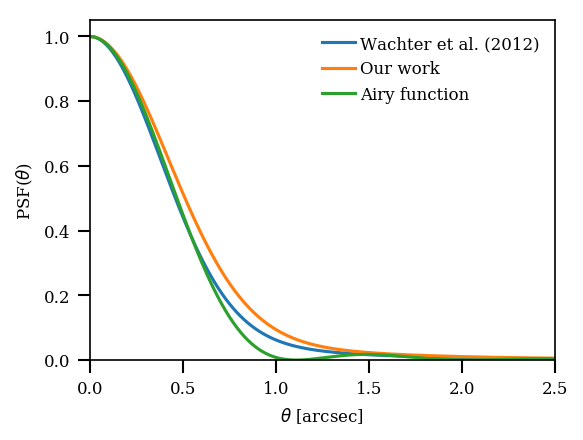

In [8]:
theta = np.arange(1e-5,3,0.01)
lambdai = 6173e-10
D = 0.14
r = np.pi*D*theta/lambdai/206265.

res =1.22*lambdai/D*206265.
print('Ideal resolution: {0:2.2f} [arcsec]\n'.format(res))

plt.figure(figsize=(4,3))
plt.rcParams['font.size'] = 8
plt.plot(theta,old_PSF(r),label='Wachter et al. (2012)')
plt.plot(theta,new_PSF(r),label='Our work')
plt.plot(theta,airyR(theta,res),label='Airy function')
plt.ylim(0.,1.05); plt.xlim(0,2.5)
plt.ylabel(r'PSF($\theta$)'); plt.xlabel(r'$\theta$ [arcsec]')
plt.legend()

In [9]:
# Here we define the 3D shape of the PSF, and not only the radial profile

def new_PSF3D():
    # We refill the Airy PSF created by astropy with our new values
    # The radius of the Airy disk kernel [in pixels]
    radio_aprx = 1.1/(0.0662)
    psfs0 = AiryDisk2DKernel(radio_aprx)

    psfs1 = np.copy(psfs0)
    x0, y0 = psfs0.center
    for ypos in range(psfs1.shape[0]):
        for xpos in range(psfs1.shape[1]):
            rr = (np.sqrt(abs(xpos-x0)**2.+abs(ypos-y0)**2.))
            rr_pix = rr*np.pi*D/lambdai/206265.*0.0662
            psfs1[ypos,xpos] = new_PSF(rr_pix)
    psfs1 /= np.sum(psfs1)
    return psfs1

def old_PSF3D():
    # We refill the Airy PSF created by astropy with our new values
    # The radius of the Airy disk kernel [in pixels]
    radio_aprx = 1.1/(0.0662)
    psfs0 = AiryDisk2DKernel(radio_aprx)

    psfs1 = np.copy(psfs0)
    x0, y0 = psfs0.center
    for ypos in range(psfs1.shape[0]):
        for xpos in range(psfs1.shape[1]):
            rr = (np.sqrt(abs(xpos-x0)**2.+abs(ypos-y0)**2.))
            rr_pix = rr*np.pi*D/lambdai/206265.*0.0662
            psfs1[ypos,xpos] = old_PSF(rr_pix)
    psfs1 /= np.sum(psfs1)
    return psfs1

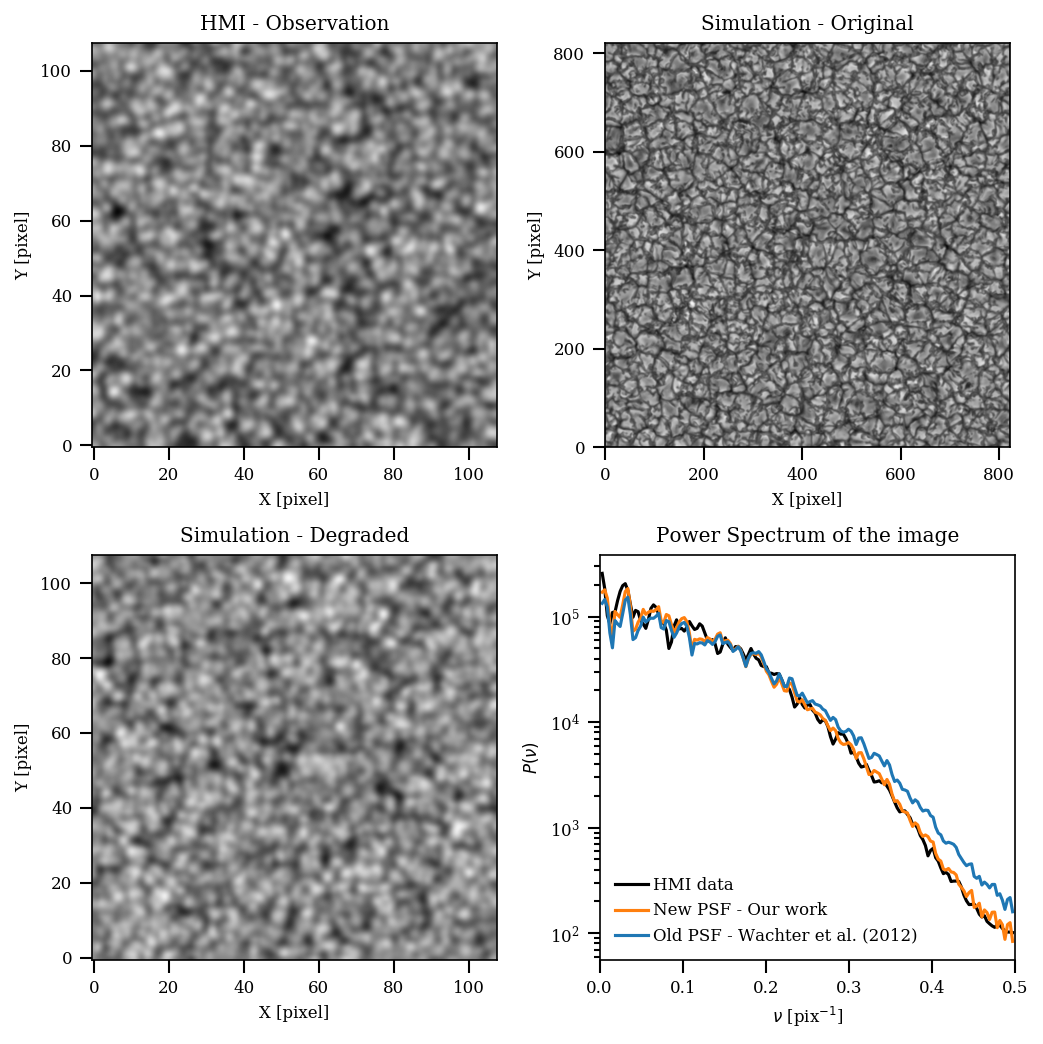

In [10]:
# We load two images of QS from the simulation and from the HMI satellite
imSIMU = np.load('simulation.npy'); imHMI = np.load('hmi.npy')
plt.rcParams['font.size'] = 8

dx = 108 # Size of the sample

plt.figure(figsize=(7,7))
plt.subplot(221)
pHMI = imHMI[:dx,:dx]
plt.title('HMI - Observation')
plt.imshow(pHMI,cmap='gray',origin='lower',interpolation='bicubic')
plt.xlabel('X [pixel]'); plt.ylabel('Y [pixel]')

plt.subplot(222)
plt.title('Simulation - Original')
pSIMU = imSIMU[:int(dx/0.0662*0.504),:int(dx/0.0662*0.504)]
plt.imshow(pSIMU,cmap='gray',origin='lower',interpolation='bicubic')
plt.xlabel('X [pixel]'); plt.ylabel('Y [pixel]')
yticki = [0,200,400,600,800]
plt.yticks(yticki); plt.xticks(yticki)


# We convolve both PSFs to compare later the images
new_SIMU = convolve_fft(pSIMU,new_PSF3D(),boundary='wrap')
old_SIMU = convolve_fft(pSIMU,old_PSF3D(),boundary='wrap')

# Now we resample the original images to the HMI sampling
pnew_SIMU = resample(new_SIMU[:int(dx/0.0662*0.504),:int(dx/0.0662*0.504)],[dx,dx])
pold_SIMU = resample(old_SIMU[:int(dx/0.0662*0.504),:int(dx/0.0662*0.504)],[dx,dx])


plt.subplot(223)
plt.title('Simulation - Degraded')
plt.imshow(pnew_SIMU,cmap='gray',origin='lower',interpolation='bicubic')
plt.xlabel('X [pixel]'); plt.ylabel('Y [pixel]')


plt.subplot(224)
# We calculate the FFT of each image to a better comparison
v, psf1D = fft1D(pHMI)
v2, psf1D2 = fft1D(pnew_SIMU)
v3, psf1D3 = fft1D(pold_SIMU)

plt.semilogy(v,psf1D,label='HMI data',c='k')
plt.semilogy(v2,psf1D2,label='New PSF - Our work',c='C1')
plt.semilogy(v3,psf1D3,label='Old PSF - Wachter et al. (2012)',c='C0')
plt.xlim(0,0.5); plt.legend()
plt.title('Power Spectrum of the image')
plt.xlabel(r'$\nu$ [pix$^{-1}$]')
plt.ylabel(r'$P(\nu)$')
plt.tight_layout()

<a id="fig:database"></a>
**Figure 5** — Upper left: HMI observation. Upper right: snapshot from the simulation used for training. Lower left: degraded simulations, which can be compared with the HMI observations. Lower right: azimuthally averaged power spectrum of the HMI observations and the degraded simulations with the original PSF and the one modified and used in the training process. The physical dimension of the three maps is 54$\arcsec$$\times$54$\arcsec$.

---

Then, we randomly extract 50000 patches of $50\times 50$ pixels both spatially and temporally, which will constitute the input patches of the training set. We also randomly extract a smaller subset of 5000 patches which will act as a validation set to avoid overfitting. These are used during the training to check that the CNN generalizes well and is not memorizing the training set. The targets of the training set are obtained similarly but convolving with the Airy function of a telescope twice the diameter of HMI (28 cm), which gives a diffraction limit of $0.55"$/pixel, and then resampled to $0.25"$/pixel. Therefore, the sizes of the output patches are $100 \times 100$ pixels. All inputs and outputs for the continuum images are normalized to the average intensity of the quiet Sun. This is very convenient when the network is 
deployed in production because this quantity $I/Ic$ is almost always available. On the contrary, the magnetograms are divided by 10$^3$, so they are treated in kG during the training. The training of the network is carried out by minimizing a loss function defined as the squared difference between the output of the network and the desired output defined on the training set. To this end, we use the Adam stochastic optimizer [(Kingma & Ba 2014)](#references) with a learning rate of $\eta=10^{-4}$. The training is done in a Titan X GPU for 20 epochs, taking $\sim 500$ seconds per epoch. We augment the loss function with an $\ell_2$ regularization for the elements of the kernels of all convolutional layers to avoid overfitting. Finally, we add Gaussian noise (with an amplitude of 10$^{-3}$ in units of the continuum intensity for the continuum images and 10$^{-2}$ for the magnetograms, following [HMI standard specifications specifications](http://hmi.stanford.edu/Description/HMI\_Overview.pdf)) to stabilize the training and produce better quality predictions. This is important for regions of low contrast in the continuum images and regions of weak magnetic fields in the magnetograms.

Apart from the size and number of kernels, there are a few additional hyperparameters that need to be defined in `Enhance`. The most important ones are the number of residual blocks, the learning rate of the Adam optimizer and the amount of regularization. We have found stable training behavior with a learning rate of $10^{-4}$ so we have kept this fixed. Additionally, we found that a regularization weight of $10^{-6}$ for the continuum images and $10^{-5}$ for the magnetograms provides nice and stable results. 

Finally, five residual blocks with $\sim$450k free parameters provide predictions that are almost identical to those of 10 and 15 residual blocks, but much faster. We note that the number of residual blocks can be further decreased even down to one and a good behavior is still found (even if the number of kernels is decreased to 32). This version of `Enhance` is six times faster than the one presented here, reducing the number of parameters to $\sim$40k, with differences
around 3%. Although `Enhance` is already very fast, this simplified version can be used for an in-browser online super-resolution and deconvolution of HMI data.



```python
# This is an pseudocode example of the training process using keras. See the full version in the repository:
# https://github.com/cdiazbas/enhance/blob/master/train.py

# We asign the loss function and the optimizer with the learning rate to the model class
model.compile(loss='mean_squared_error', optimizer=Adam(lr))

# And then we start the training process with the described data. Usually the method fit() is used 
# when the dataset can be allocated in memory and fit_generator() for larger datasets.
model.fit_generator(training_data, batchsize, epochs, validation_data)

# After this last process the NN can be used to do predictions in the same way:
prediction_data = model.predict(input_data)
```

---

## Results
### Validation with synthetic images

Before proceeding to applying the networks to real data, we show in Fig. [6](#fig:validation_synthetic) the results with some of the patches from the validation set which are not used during the training. The upper three rows show results for the continuum images, while the lower three rows show results for the magnetograms. The leftmost column is the original synthetic image at the resolution of HMI. The rightmost column is the target that should be recovered by the network, which has doubled the number of pixels in each dimension. The middle column displays our single-image superresolution results.


Even though the appearance of all small-scale details are not exactly similar to the target, we consider that `Enhance`  is doing a very good job in deconvolving and super-resolving the data in the first column. In the regions of increased activity, we find that we are able to greatly improve the fine structure, specially in the penumbra. Many details are barely visible in the synthetic HMI image but can be guessed. Of special relevance are the protrusions in the umbra in the third row, which are very well recovered by the neural network. The network also does a very good job in the quiet Sun, correctly recovering the expected shape of the granules from the blobby appearance in
the HMI images.

<a id="fig:validation_synthetic"></a>
<img src="docs/validation_cont.png" width="70%"/><img src="docs/validation_blos.png" width="70%"/>

**Figure 7** — Upper left: HMI observation. Upper right: snapshot from the simulation used for training. Lower left: degraded simulations, which can be compared with the HMI observations. Lower right: azimuthally averaged power spectrum of the HMI observations and the degraded simulations with the original PSF and the one modified and used in the training process. The physical dimension of the three maps is 54$\arcsec$$\times$54$\arcsec$.

###  In the wild
The trained networks are then applied to real HMI data. In order to validate the output of our neural network we have selected observations of the Broadband Filter Instrument (BFI) from the Solar Optical Telescope [(SOT, Ichimoto et al. 2008; Tsuneta et al. 2008)](#references) onboard Hinode [(Kosugi et al. 2007)](#references). The pixel size of the BFI is $0.109"$ and the selected observations were obtained in the red continuum filter at $6684 \pm 2$ ${\AA}$, which is the one closer to the observing wavelength of HMI. To properly compare our results with Hinode, we have convolved the BFI images with an Airy function of a telescope of 28 cm diameter and resampled to $0.25"$/pixel to match those of the output of `Enhance`. The Hinode images have not been deconvolved from the influence of its PSF. We point out that the long tails of the PSF of the Hinode/SOT instrument produce a slight decrease in the contrast [(Danilovic et al. 2010)](#references)  and this is the reason why our enhanced images have a larger contrast.

### Continuum images

Figure [7](#fig:subplot) displays this comparison for two different regions (columns) observed simultaneously
with Hinode and HMI. These two active regions are: NOAA 11330 (N09, E04) observed on October 27, 2011 
(first column), and NOAA 12192 (S14, E05) observed on October 22, 2014 (second column). We have used HMI images with a cadence of 45 seconds, which is the worst scenario in terms of noise in the image. The upper rows show the original HMI images. The lower rows display the degraded Hinode images, while the central row shows the output of our neural network. Given the fully convolutional character of the deep neural network used in this work, it can be applied seamlessly to input images of arbitrary size. As an example, an image of size $400 \times 400$ can be super-resolved and deconvolved in $\sim$100 ms using a Titan X GPU, or $\sim$1 s using a 3.4 GHz Intel Core i7.


<a id="fig:subplot"></a>
<img src="docs/column34.png" width="80%"/>
**Figure 7** — Application of the neural network to real HMI images. From the upper to the lower part of each column: the original HMI images, the output of the neural network, and the degraded Hinode image. All the axes are in pixel units.

The contrast $\sigma_I/I$, calculated as the standard deviation of the continuum intensity divided by the
average intensity of the area, is quoted in the title of each panel and has been obtained in a small region of the image 
displaying only granulation. The granulation contrast increases from $\sim$3.7% to $\sim$7% [(as Couvidat et al. 2016)](#references), almost a factor two larger than the one provided by degraded Hinode. We note that the contrast may be slightly off for the right column because of the small quiet Sun area available. The granulation contrast measured in 
Hinode without degradation is around 7%. After the resampling, it goes down to the values quoted in the figure. We note that [(Danilovic et al. 2008)](#references) analyzed the Hinode granulation contrast at 630 nm and concluded that it is 
consistent with those predicted by the simulations (in the range 14$-$15%) once the PSF is taken into account. From a visual point of view, it is clear that `Enhance` produces small-scale structures that are almost absent in the HMI images
but clearly present in the Hinode images. Additionally, the deconvolved and super-resolved umbra intensity decreases between 3 and 7% when compared to the original HMI umbral intensity. Interesting cases are the large light bridge in the images of the right column, that increases in spatial complexity. Another example is the regions around the light bridge, which are plagued with small weak umbral dots that are evident in Hinode data but completely smeared out in HMI. For instance, the region connecting the light bridge at (125, 240) with the penumbra. Another similar instance of this enhancement occurs (375, 190); a pore with some umbral dots that are almost absent in the HMI images.

As a caveat, we warn the users that the predictions of the neural network in areas close to the limb is poorer than those at disk center. Given that `Enhance` was trained with images close to disk center, one could be tempted to think that a lack of generalization is the cause for the failure.

In [11]:
# Here we describe how to use ENHANCE
# using a region close to the limb as an example:
mymap = fits.open('hmi_20111102_000029_continuum.fits')
dat = np.nan_to_num(mymap[1].data)

In [13]:
# We only want a small region
submap = dat[1700:2100,0:500]
# and it has to be normalized to the QS.
maxim = np.max(dat[0:,0:])
submap = submap/maxim
#submap = submap/np.mean(submap[:,400:])


# The image have to be save in fits format
hdu = fits.PrimaryHDU(submap)
os.system('rm samples/nhmi.fits')
hdu.writeto('samples/nhmi.fits')

In [14]:
# Then, we run our code as it is explained in the repository:

In [15]:
run enhance.py -i samples/nhmi.fits -t intensity -o output/hmi_enhanced.fits

Model : intensity
Setting up network...
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading weights...
Predicting validation data...
Prediction took 5.7 seconds...
Saving data...
Overwriting...


<Figure size 900x600 with 0 Axes>

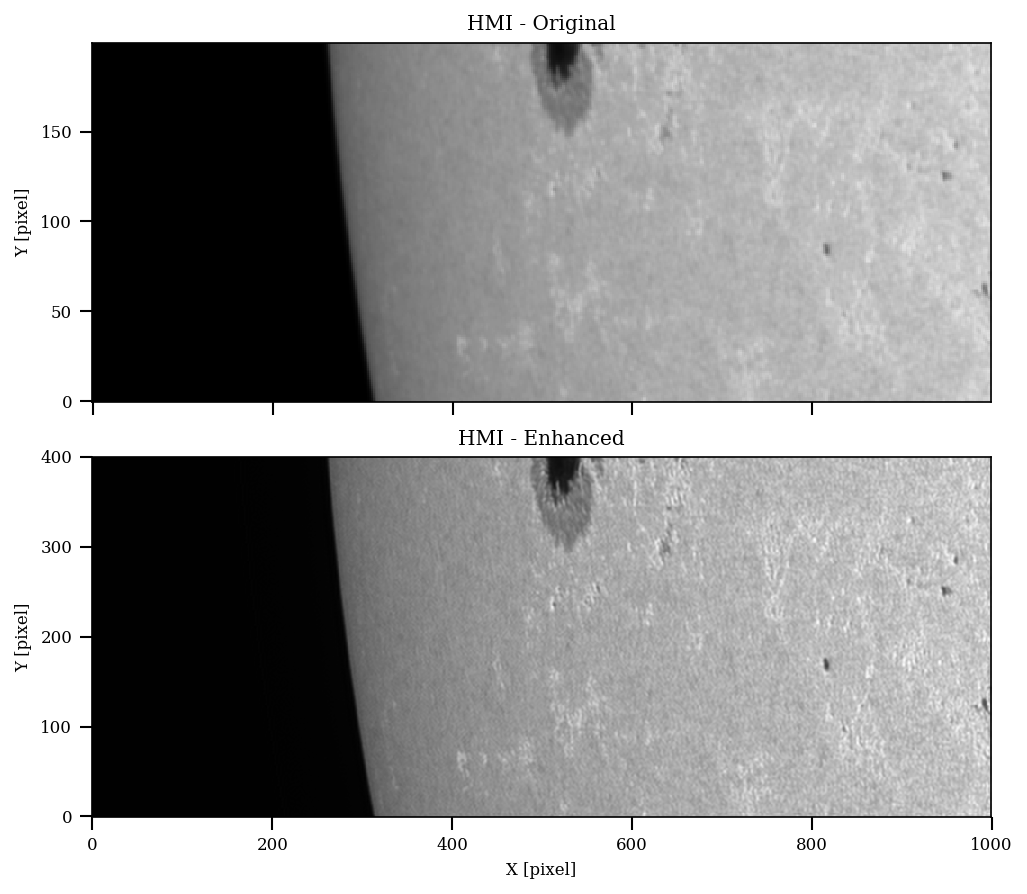

In [16]:
plt.figure(figsize=(10,6))
plt.rcParams['font.size'] = 8

mymap2 = fits.open('output/hmi_enhanced.fits')
submap2 = np.nan_to_num(mymap2[0].data)
plt.subplot(212); plt.title('HMI - Enhanced')
plt.imshow(submap2[0:400,:],cmap='gray',interpolation='None',vmin=submap2.min(),vmax=submap2.max())
plt.xlabel('X [pixel]'); plt.ylabel('Y [pixel]')
plt.locator_params(axis='y', nbins=4)
plt.tight_layout()

plt.subplot(211); plt.title('HMI - Original')
plt.imshow(submap[0:200,:],cmap='gray',interpolation='None',vmin=submap2.min(),vmax=submap2.max())
plt.tick_params(axis='x',labelbottom='off'); plt.ylabel('Y [pixel]')
plt.tight_layout()
plt.locator_params(axis='y', nbins=4)

However, we note that structures seen in the limb, such as elongated granules, share some similarity to some penumbral filaments, so these cases are already present in the training set.
The fundamental reason for the failure is that the spatial contrast in the limb is very small, so the neural network does not know how to reconstruct the structures, thus creating artifacts. We speculate that these artifacts will not be significantly reduced even if limb synthetic observations are included in the training set.

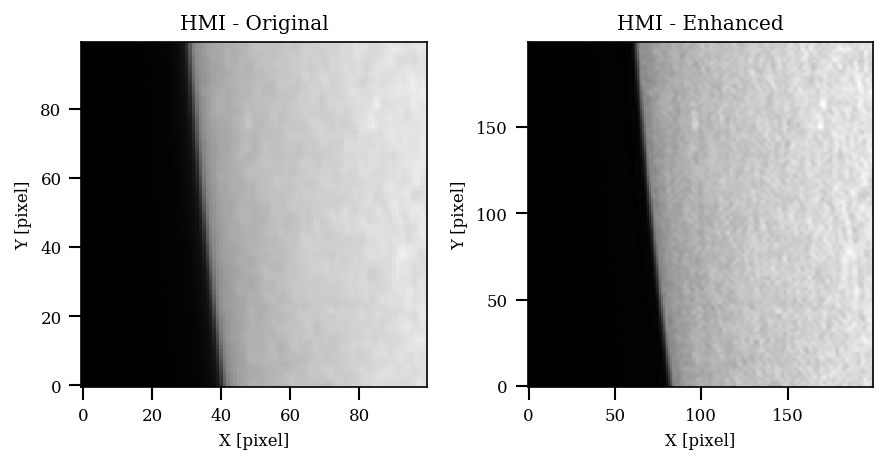

In [17]:
plt.figure()
plt.rcParams['font.size'] = 8

plt.subplot(122); plt.title('HMI - Enhanced')
plt.imshow(submap2[200:400,200:400],cmap='gray',interpolation='None',vmax=np.max(submap2[200:400,200:400]))
plt.xlabel('X [pixel]'); plt.ylabel('Y [pixel]'); plt.locator_params(axis='y', nbins=4)

plt.subplot(121); plt.title('HMI - Original')
plt.imshow(submap[100:200,100:200],cmap='gray',interpolation='None',vmax=np.max(submap2[200:400,200:400]))
plt.xlabel('X [pixel]'); plt.ylabel('Y [pixel]')
plt.tight_layout()

### A magnetogram example: AR 11158
As a final example, we show in Fig. [8](#fig:bigplot) an example of the neural network applied to the intensity and the magnetogram for the same region: the NOAA 11158 (S21, W28), observed on February 15, 2011. The FOV is divided into two halfs. The upper parts show the HMI original image both for the continuum image (left panel) and the magnetogram (right panel). The lower parts display the enhanced images after applying the neural network.

> Note: This active region has been studied in the past. See for example: http://iopscience.iop.org/article/10.1088/0004-637X/783/2/98/pdf



<a id="fig:bigplot"></a>
<img src="docs/figure7b.png" width="100%"/>
**Figure 8** — An example of our neural network applied to the intensity (left) and magnetogram (right) for the same region. The FOV is divided into two halves. The upper half shows the HMI original image, without applying the neural network. The lower half shows enhanced image applying the neural network to the last image. The original image was resampled to have the same scale as the network output.

---

After the deconvolution of the magnetogram, we find that: i) regions with very nearby opposite polarities suffer from an apparent cancellation in HMI data that can be restored with `Enhance`, giving rise to an increase in the 
absolute value of the longitudinal field; and ii) regions far from magnetized areas become contaminated by the surroundings in HMI, which are also compensated for with `Enhance`, returning smaller longitudinal
fields. The left panel of Fig. [9](#fig:powerBlos) shows the density plot of the input versus output longitudinal magnetic field. Almost all the points lie in the 1:1 relation. However, points around 1 kG for HMI are
promoted to larger absolute values, a factor $\sim 1.3 - 1.4$ higher than the original image [(Couvidat et al. 2016)](#references).

Another interesting point to study is the range of spatial scales at which `Enhance` is adding information. The right panel of Fig. [9](#fig:powerBlos) displays the power spectrum of both magnetograms showed in the right part of Fig. [8](#fig:bigplot). The main difference between both curves is situated in the range of spatial scales $\nu = 0.05-0.25$ pix$^{-1}$ with a peak at $\nu=0.15$ pix$^{-1}$. In other words, the neural network is operating mainly at scales between 4 and 20 pixels, where the smearing effect of the PSF is higher.

The same effect can be seen when a standard Richardson--Lucy maximum-likelihood algorithm (RL) (including a bilinear interpolation to carry out the super-resolution) is used (see [next section](#sec:RL) for more details). The power spectrum of the output of `Enhance` and the one deconvolved with RL are almost the same for frequencies below 0.15 pix$^{-1}$ (equivalent to scales above $\sim 6$ pix). For larger frequencies (smaller scales), the RL version adds noisy 
small scale structures at a level of $\sim$80 G; this is not case with `Enhance`. We note that the original image has a noise around $\sim$10 G. To quantify this last point, we have showed in Fig. [9](#fig:powerBlos) the flat spectrum of white noise artificial images with zero mean and standard deviations $\sigma=12$G and $\sigma=75$G.


<a id="fig:powerBlos"></a>
<img src="docs/2plots.png" width="100%"/>
**Figure 9** — Left: scatter plot between the original magnetogram signal and the deconvolved magnetogram signal. Dotted lines indicate a change of a factor two. Right: spatial Fourier power spectrum of all considered magnetograms: the original, the output of Enhance and the one deconvolved with RL. We also show the power spectrum of white noise at two different levels.

---

### Other general properties

Depending on the type of structure analyzed, the effect of the deconvolution is different. In plage regions, where the magnetic areas are less clustered than in a sunspot, the impact of the stray light is higher. Then, `Enhance` produces a magnetic field that can increase up to a factor two [(Yeo et al. 2014)](#references), with magnetic structures smaller in size, as signal smeared onto the surrounding quiet Sun is returned to its original location. According to the left panel of Fig [9](#fig:powerBlos), fields with smaller amplitudes suffer a larger relative change. As a guide to the eye, the two dotted lines indicate a change of a factor two in the same figure.



To check these conclusions, we have used a Hinode-SOT Spectropolarimeter (SP) [(Lites et al. 2013)](#references) Level 1D[$^{[5]}$](#footnote_sot) magnetogram. The region was observed in April 25, 2015, at 04:00h UT and its pixel size is around 0.30''/pix. Figure [10](#fig:compararPlage) shows the increase of the magnetic field after the deconvolution: magnetic fields of kG flux were diluted by the PSF and recovered with `Enhance`. It was impossible to find the Hinode map of exactly the same region at exactly the same moment, meaning that some differences are visible. However the general details are retrieved. In regions of strong concentrations, like the ones found in Fig. [8](#fig:bigplot), almost each polarity is spatially concentrated and increased by a factor below 1.5.

<a id="footnote_sot"></a>
> 5.- Hinode-SOT Spectropolarimeter(SP) Data Product Description and Access: http://sot.lmsal.com/data/sot/level1d/


The magnetogram case is more complex than the intensity map. Many studies [(Krivova & Solanki 2004; Pietarila et al. 2013; Bamba et al. 2014)](#references) have demonstrated the impact of the resolution to estimate a value of the magnetic flux and products of the magnetogram as nonlinear force-free extrapolations [(Tadesse et al. 2013; DeRosa et al. 2015)](#references), to compare with in--situ spacecraft measurements [(Linker et al. 2017)](#references). 

Contrary to deconvolving intensity images, deconvolving magnetograms is always a very delicate issue. The difficulty relies on the presence of cancellation produced during the smearing with a PSF if magnetic elements of opposite polarities are located nearby. This never happens for intensity images, which are always non-negative. Consequently, one can arbitrarily increase the value of nearby positive and negative polarities while maintaining a small quadratic approximation to the desired output. This effect is typically seen when a standard RL algorithm is used for
deconvolution.

`Enhance` avoids this effect by learning suitable spatial priors from the training dataset. It is true that the method will not be able to separate back two very nearby opposite polarities that have been fully canceled by the smearing of the PSF. Extensive tests show that the total absolute flux of each deconvolved image is almost the same as that
in the original image, that is, the magnetic field is mainly "reallocated".

<a id="fig:compararPlage"></a>
<img src="docs/compararPlage.png" width="100%"/>
**Figure 10** — Left: original HMI magnetogram of a plage region observed on April 25, 2015. Middle: the result of applying Enhance to the HMI magnetogram. Right: the Hinode magnetogram at the same resolution of Enhance. The magnetic flux has been clipped from −1kG to 1kG.

---

<a id="sec:RL"></a>
### Comparison with a standard RL deconvolution algorithm

As a final step, we compare our results with those of a RL algorithm in a complicated case. Figure [11](#fig:compara2) shows the same image deconvolved with both methods. The output of `Enhance` is similar to the output of the RL method. Some noisy artifacts are detected in areas with low magnetic-field strength.

A detailed analysis can reveal some differences however. In the light--bridge (LB), the magnetic field is lower in the RL version. Additionally, the polarity inversion line (PIL) appears sharper and broader in the RL version than in the `Enhance` one. The magnetic flux in both areas (LB and PIL) is reduced by a factor 0.5, which might be an indication of
too many iterations. The magnetic field strength of the umbra is between 50G and 80G higher in the RL version.

As a final test, we checked the difference between the original image and the output of `Enhance` convolved with the PSF. The average relative difference is around 4% (which is in the range 10-80G depending on the flux of the pixel), 
which goes down to less than 1% in the RL case (this is a clear indication that `Enhance` is introducing prior information not present in the data). Additionally, our network is orders of magnitude faster than RL, it does not create  noisy artifacts and the estimation of the magnetic field is as robust as a RL method.

In [18]:
def rlucy(raw, psf, niter=2, damped=False, verbose=False):
    """ working on it"""
    from astropy.convolution import convolve_fft as convolve

    psf /= psf.sum()
    lucy = np.ones(raw.shape) * raw.mean()
    
    for i in range(niter):
        ratio = raw / convolve(lucy, psf, boundary='wrap')
        ratio[ np.isnan(ratio) ] = 0
        top = convolve( ratio, psf, boundary='wrap')
        top[ np.isnan(top) ] = 0

        lucy = lucy * top 
        dife = np.abs(convolve(lucy, psf, boundary='wrap') - raw)
        chisq = np.nanmedian(dife)
        if verbose: print('iteration', i,chisq)
        
        if damped:
            umbral = chisq*10.0
            lucy[dife>umbral] = raw[dife>umbral]

    return lucy


def new_PSF_scaled():
    # We refill the Airy PSF created by astropy with our new values
    # The radius of the Airy disk kernel [in pixels]
    radio_aprx = 1.1/(0.504302/2.)
    psfs0 = AiryDisk2DKernel(radio_aprx)

    psfs1 = np.copy(psfs0)
    x0, y0 = psfs0.center
    for ypos in range(psfs1.shape[0]):
        for xpos in range(psfs1.shape[1]):
            rr = (np.sqrt(abs(xpos-x0)**2.+abs(ypos-y0)**2.))
            rr_pix = rr*np.pi*D/lambdai/206265.*(0.504302/2.)
            psfs1[ypos,xpos] = new_PSF(rr_pix)
    psfs1 /= np.sum(psfs1)
    return psfs1


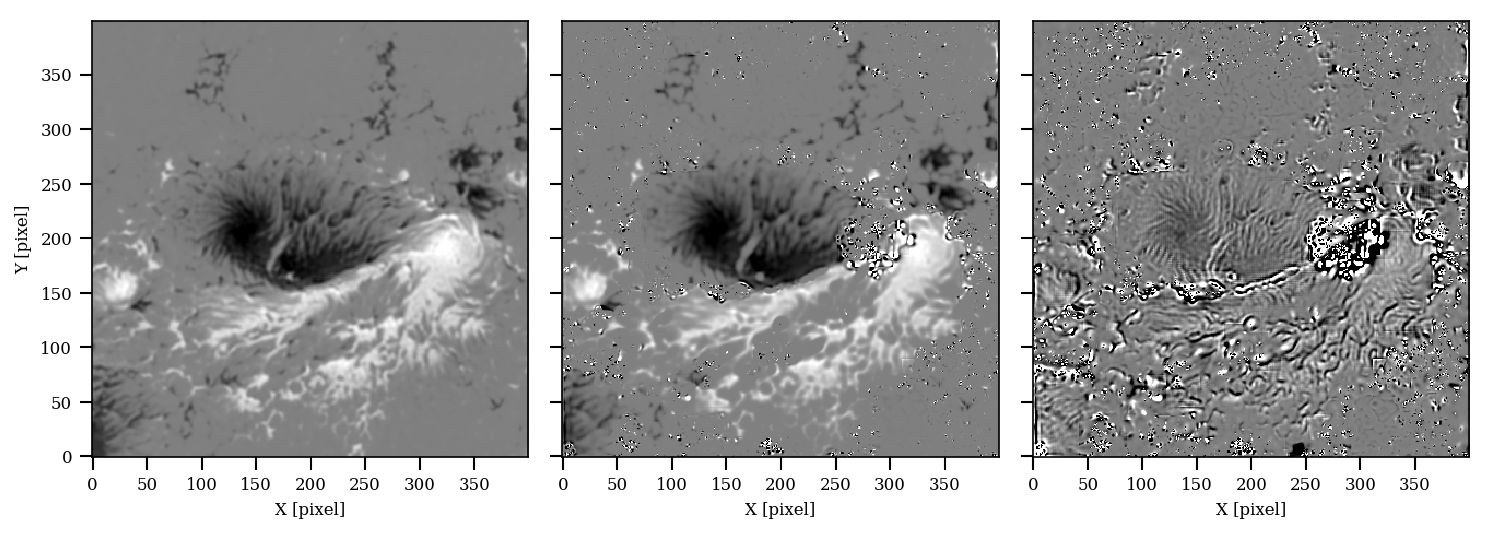

In [19]:
# As we will deconvolve the interpolated version of the 
# magnetogram, we also need to scale the PSF
psfHMI = new_PSF_scaled()

# We load the magnetograms in kG
pHMI = np.load('blos_paper0.npy')*1000.
pEhnhace = np.load('blos_paper1.npy')*1000.


# NOTE: we have implemented a damping method to avoid very large values.
# It can be enable/disabled using damped=True/False in this function:
pLucy = rlucy(pHMI, psf=psfHMI, niter=20, damped=False, verbose=False)

plt.figure(figsize=(10,3.5))
plt.rcParams['font.size'] = 8

plt.subplot(131)
plt.imshow(pEhnhace,vmin=-1500,vmax=1500,cmap='gray',interpolation='None')
plt.xlabel('X [pixel]'); plt.ylabel('Y [pixel]')

plt.subplot(132)
plt.imshow(pLucy,vmin=-1500,vmax=1500,cmap='gray',interpolation='None')
plt.xlabel('X [pixel]'); plt.tick_params(axis='y',labelleft='off');
plt.tight_layout()

plt.subplot(133)
plt.imshow(pLucy-pEhnhace,vmin=-200,vmax=200,cmap='gray',interpolation='None')
plt.xlabel('X [pixel]'); plt.tick_params(axis='y',labelleft='off');
plt.tight_layout()

<a id="fig:compara2"></a>
**Figure 11** — Left: the output of Enhance. Middle: output after applying a Richardson-Lucy method to deconvolve the image. Right: the difference between the RL version and the Enhance output. The magnetic flux has been clipped to ±1.5kG and ±200G in the last image.

---

## Conclusions and future work
This paper presents the first successful deconvolution and super-resolution applied on solar images using deep convolutional neural network. It represents, after [Asensio Ramos et al. (2017)](#references), a new step toward the implementation of new machine learning techniques in the field of solar physics.

Single-image super-resolution and deconvolution, either for continuum images or for magnetograms, is an ill-defined problem. It requires the addition of extra knowledge for what to expect in the high-resolution images. The deep learning approach presented in this paper extracts this knowledge from the simulations and also applies a deconvolution. All this
is done very quickly, almost in real-time, and to images of arbitrary size. We hope that `Enhance` will allow researchers to study small-scale details in HMI images and magnetograms, something that is currently impossible.

Often, HMI is used not as the primary source of information but as a complement for ground-based observations, providing the context. For this reason, having enhanced images where you can analyze the context with increased resolution is interesting.

We have preferred to be conservative and only do super-resolution by a factor two. We carried out some tests with a larger factor, but the results were not satisfactory. Whether or not other techniques proposed in this explosively growing field can work better remains to be tested. Among others, techniques like a gradual up-sampling  [(Zhao et al. 2017)](#references), recursive convolutional layers [(Kim et al. 2015)](#references), recursive residual blocks [(Tai et al. 2017)](#references), or using adversarial networks as a more elaborate loss function [(Ledig et al. 2016; Schawinski et al. 2017)](#references) could potentially produce better results.

We provide `Enhance` hosted on https://github.com/cdiazbas/enhance as an open-source tool, providing the 
methods to apply the trained networks used in this work to HMI images or re-train them using new data. In the future, we plan to extend the technique to other telescopes/instruments to generate super-resolved and deconvolved images.



---

*We would like to thank Monica Bobra and her collaborators for promoting these new methods of analysis to be used in solar physics and for inviting us to do it with this contribution.*

*As this chapter is based on a publication in A&A, 614, A5 (2018) we also like to thank the anonymous referee of our article. We thank Mark Cheung for kindly sharing with us the simulation data, without which this study would not have been possible.* 

*Financial support by the Spanish Ministry of Economy and Competitiveness through project AYA2014-60476-P is gratefully acknowledged. CJDB acknowledges Fundaci\'on La Caixa for the financial support received in the form of a PhD contract.* 

*We also thank the NVIDIA Corporation for the donation of the Titan X GPU used in this research. This research has made use of NASA's Astrophysics Data System Bibliographic Services.*

*We acknowledge the community effort devoted to the development of the following open-source packages that were used in this work: numpy (numpy.org), matplotlib (matplotlib.org), Keras (keras.io), Tensorflow (tensorflow.org)
and SunPy (sunpy.org).*




---

------

## References
<a id="references"></a>

- [Asensio Ramos, A. & de la Cruz Rodríguez, J. 2015, A&A, 577, A140](https://www.aanda.org/articles/aa/abs/2015/05/aa25508-14/aa25508-14.html)
- [Asensio Ramos, A., Requerey, I. S., & Vitas, N. 2017, A&A, 604, A11](https://www.aanda.org/articles/aa/abs/2017/08/aa30783-17/aa30783-17.html)
- [Asensio Ramos, A. & Socas-Navarro, H. 2005, A&A, 438, 1021](https://www.aanda.org/articles/aa/abs/2005/30/aa2865-05/aa2865-05.html)
- [Bamba, Y., Kusano, K., Imada, S., & Iida, Y. 2014, PASJ, 66, S16](https://academic.oup.com/pasj/article/66/SP1/S16/1459365)
- [Bello González, N., Yelles Chaouche, L., Okunev, O., & Kneer, F. 2009, A&A, 494, 1091](https://www.aanda.org/component/article?access=bibcode&bibcode=&bibcode=2009A%2526A...494.1091BFUL)
- [Bishop, C. M. 1996, Neural networks for pattern recognition (Oxford University Press)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.679.1104&rep=rep1&type=pdf)
- [Borman, S. & Stevenson, R. L. 1998, Midwest Symposium on Circuits and Systems, 374](http://www.seanborman.com/publications/mwscas98.pdf)
- [Carroll, T. A. & Kopf, M. 2008, A&A, 481, L37](http://adsabs.harvard.edu/abs/2008A%26A...481L..37C)
- [Cheung, M. C. M., Rempel, M., Title, A. M., & Schüssler, M. 2010, ApJ, 720, 233](http://adsabs.harvard.edu/abs/2010ApJ...720..233C)
- [Ciuca, R., Hernández, O. F., & Wolman, M. 2017, ArXiv e-prints arXiv:1708.08878](https://arxiv.org/abs/1708.08878)
- [Colak, T. & Qahwaji, R. 2008, Sol. Phys., 248, 277](https://link.springer.com/article/10.1007%2Fs11207-007-9094-3)
- [Colak, T., & Qahwaji, R. 2008, Sol. Phys., 248, 277](http://adsabs.harvard.edu/abs/2008SoPh..248..277C)
- [Couvidat, S., Schou, J., Hoeksema, J. T., et al. 2016, Sol. Phys., 291, 1887](http://adsabs.harvard.edu/abs/2016SoPh..291.1887C)
- [Danilovic, S., Gandorfer, A., Lagg, A., et al. 2008, A&A, 484, L17](http://adsabs.harvard.edu/abs/2008A%26A...484L..17D)
- [Danilovic, S., Schüssler, M., & Solanki, S. K. 2010, A&A, 513, A1](http://adsabs.harvard.edu/abs/2010A%26A...513A...1D)
- [DeRosa, M. L., Wheatland, M. S., Leka, K. D., et al. 2015, ApJ, 811, 107](http://adsabs.harvard.edu/abs/2015ApJ...811..107D)
- [Dong, C., Change Loy, C., He, K., & Tang, X. 2015, ArXiv e-prints arXiv:1501.00092](https://arxiv.org/abs/1501.00092)
- [Dong, C., Change Loy, C., & Tang, X. 2016, ArXiv e-prints arXiv:1608.00367](https://arxiv.org/abs/1608.00367)
- [Hayat, K. 2017, ArXiv e-prints arXiv:1706.09077](http://adsabs.harvard.edu/abs/2017arXiv170609077H)
- [He, K., Zhang, X., Ren, S., & Sun, J. 2015, ArXiv e-prints arXiv:1512.03385](https://arxiv.org/abs/1512.03385)
- [Ichimoto, K., Lites, B., Elmore, D., et al. 2008, Sol. Phys., 249, 233](http://adsabs.harvard.edu/abs/2008SoPh..249..233I)
- [Ioffe, S., & Szegedy, C. 2015, ICML-15, eds. D. Blei, & F. Bach, 448](https://arxiv.org/abs/1502.03167)
- [Kim, J., Lee, J. K., & Lee, K. M. 2015, ArXiv e-prints arXiv:1511.04491](http://adsabs.harvard.edu/abs/2015arXiv151104491K)
- [Kingma, D. P., & Ba, J. 2014, ArXiv e-prints arXiv:1412.6980](http://adsabs.harvard.edu/abs/2014arXiv1412.6980K)
- [Kosugi, T., Matsuzaki, K., Sakao, T., et al. 2007, Sol. Phys., 243, 3](http://adsabs.harvard.edu/abs/2007SoPh..243....3K)
- [Krivova, N. A., & Solanki, S. K. 2004, A&A, 417, 1125](http://adsabs.harvard.edu/abs/2004A%26A...417.1125K)
- [LeCun, Y., & Bengio, Y. 1998, ed. M. A. Arbib (Cambridge, MA: MIT Press), 255](http://dl.acm.org/citation.cfm?id=303568.303704)
- [LeCun, Y., Bottou, L., Orr, G. B., & Müller, K.-R. 1998, NIPS Workshop (London, UK: Springer-Verlag), 9](http://dl.acm.org/citation.cfm?id=645754.668382)
- [Ledig, C., Theis, L., Huszar, F., et al. 2016, ArXiv e-prints arXiv:1609.04802](https://arxiv.org/abs/1609.04802)
- [Linker, J. A., Caplan, R. M., Downs, C., et al. 2017, ApJ, 848, 70](http://adsabs.harvard.edu/abs/2017arXiv170802342L)
- [Lites, B. W., Akin, D. L., Card, G., et al. 2013, Sol. Phys., 283, 579](http://adsabs.harvard.edu/abs/2013SoPh..283..579L)
- [Nair, V., & Hinton, G. E. 2010, ICML-10, (Haïfa: ACM Digital Library), 21, 807](http://www.icml2010.org/papers/432.pdf)
- [Pesnell, W. D., Thompson, B. J., & Chamberlin, P. C. 2012, Sol. Phys., 275, 3](http://adsabs.harvard.edu/abs/2012SoPh..275....3P)
- [Peyrard, C., Mamalet, F., & Garcia, C. 2015, in VISAPP, eds. J. Braz, S. Battiato, & J. F. H. Imai (Setùbal: SciTePress), 1, 84](http://www.scitepress.org/DigitalLibrary/Link.aspx?doi=10.5220%2f0005297200840091)
- [Pietarila, A., Bertello, L., Harvey, J. W., & Pevtsov, A. A. 2013, Sol. Phys., 282, 91](http://adsabs.harvard.edu/abs/2013SoPh..282...91P)
- [Quintero Noda, C., Asensio Ramos, A., Orozco Suárez, D., & Ruiz Cobo B. 2015, A&A, 579, A3](http://adsabs.harvard.edu/abs/2015A%26A...579A...3Q)
- [Richardson, W. H. 1972, J. Opt. Soc. Am, 62, 55](http://adsabs.harvard.edu/abs/1972JOSA...62...55R)
- [Ruiz Cobo, B., & Asensio Ramos A. 2013, A&A, 549, L4](http://adsabs.harvard.edu/abs/2013A%26A...549L...4R)
- [Rumelhart, D. E., Hinton, G. E., & Williams, R. J. 1986, (Cambridge, MA: MIT Press), Nature, 323, 533](http://dl.acm.org/citation.cfm?id=65669.104451)
- [Schawinski, K., Zhang, C., Zhang, H., Fowler, L., & Santhanam, G. K. 2017, MNRAS, 467, L110](http://adsabs.harvard.edu/abs/2017MNRAS.467L.110S)
- [Scherrer, P. H., Schou, J., Bush, R. I., et al. 2012, Sol. Phys., 275, 207](http://dx.doi.org/10.1007/s11207-011-9834-2)
- [Schmidhuber, J. 2015, Neural Networks, 61, 85](http://adsabs.harvard.edu/abs/2014arXiv1404.7828S)
- [Shi, W., Caballero, J., Huszár, F., et al. 2016, ArXiv e-prints arXiv:1609.05158](http://adsabs.harvard.edu/abs/2016arXiv160905158S)
- [Simonyan, K., & Zisserman, A. 2014, ArXiv e-prints arXiv:1409.1556](http://adsabs.harvard.edu/abs/2014arXiv1409.1556S)
- [Socas-Navarro, H. 2005, ApJ, 621, 545](http://adsabs.harvard.edu/abs/2005ApJ...621..545S)
- [Stein, R. F. 2012, Liv. Rev. Sol. Phys., 9, 4](http://adsabs.harvard.edu/abs/2012LRSP....9....4S)
- [Stein, R. F., & Nordlund, Å. 2012, ApJ, 753, L13](http://adsabs.harvard.edu/abs/2012LRSP....9....4S)
- [Tadesse, T., Wiegelmann, T., Inhester, B., et al. 2013, A&A, 550, A14](http://adsabs.harvard.edu/abs/2013A%26A...550A..14T)
- [Tai, Y., Yang, J., & Liu, X. 2017, Proceeding of IEEE Computer Vision and Pattern Recognition](https://ieeexplore.ieee.org/document/8099781/)
- [Tipping, M. E., & Bishop, C. M. 2003, (Cambridge, MA: MIT Press), 1303](https://papers.nips.cc/paper/2315-bayesian-image-super-resolution.pdf)
- [Tsuneta, S., Ichimoto, K., Katsukawa, Y., et al. 2008, Sol. Phys., 249, 167](http://adsabs.harvard.edu/abs/2008SoPh..249..167T)
- [van Noort, M. 2012, A&A, 548, A5](http://adsabs.harvard.edu/abs/2012A%26A...548A...5V)
- [Vögler, A., Shelyag, S., Schüssler, M., et al. 2005, A&A, 429, 335](http://adsabs.harvard.edu/abs/2005A%26A...429..335V)
- [Wachter, R., Schou, J., Rabello-Soares, M. C., et al. 2012, Sol. Phys., 275, 261](http://adsabs.harvard.edu/abs/2012SoPh..275..261W)
- [Xu, L., Ren, J. S. J., Liu, C., & Jia, J. 2014, NIPS’14 (Cambridge, MA: MIT Press), 1790](http://dl.acm.org/citation.cfm?id=2968826.2969026)
- [Yeo, K. L., Feller, A., Solanki, S. K., et al. 2014, A&A, 561, A22](http://adsabs.harvard.edu/abs/2014A%26A...561A..22Y)
- [Zhao, Y., Wang, R., Dong, W., et al. 2017, ArXiv e-prints arXiv:1703.04244](http://adsabs.harvard.edu/abs/2017arXiv170304244Z)

---